### Inverse iteration with Hessenberg reduction using Householder reflections

Inverse iteration is an iterative method for computing approximate eigenvectors of matrices when approximations to the desired eigenvalues are known.

Let $A$ be our input matrix. The inverse iteration is conceptually similar to the power iteration algorithm in which a random (non-zero) approximation of the eigenvector $v$ is constructed and iteratively multiplied by $A$ from the left. $A^{k}v$ where $k$ is the number of iterations then converges to the eigenvector corresponding to the dominant eigenvalue. The same is true for the inverse iteration algorithm except that $(A - \sigma I)^{-1}$ is used instead of $A$, where $\sigma$ is an approximation to the eigenvalue of interest. Eigenvalues of this matrix are $(\lambda_i - \sigma)^{-1}$ where $\lambda_i$ are eigenvalues of $A$, hence the method finds the eigenvector that corresponds to the smallest value of $|\lambda_i - \sigma|$. In other words it converges to the eigenvector whose eigenvalue is closest to $\sigma$. Additionally, eigenvectors of $(A - \sigma I)^{-1}$ are the same as eigenvectors of $A$.

To avoid calculating the inverse in $(A - \sigma I)^{-1}v$ we can use $PA = LU$ decomposition and solve lower and upper triangular systems $Lx = Pv_{i-1}$ and $Uv_i = x$, where $v_{i-1}$ and $v_i$ are previous and current approximations of $v$ respectively, at each iteration. To further reduce the number of operations at each iteration we can reduce $A$ to a similar upper Hessenberg matrix using Householder reflectors, i.e. $H = Q^{T}AQ$ where $A = QR$ is a QR decomposition of $A$. Because $H$ is the same linear transformation $f: V\rightarrow V$ as $A$ written in different bases of $V$ the eigenvector of $A$ is calculated as $Qv$, where $v$ is the eigenvector of $H$ and $Q$  being the change of basis matrix. One advantage of working with $H$ instead of $A$ is that LU decomposition requires significantly less computational effort. Furthermore, since no pivoting is required during Gauss elimination, multiplying $v_{i-1}$ by $P$ at each iteration can be skipped to.

An interesting remark when calculating $H = Q^{T}AQ$ is that $Q$ is never explicitly formed, but $Q_i A$ and $A Q_i^{T}$ are calculated implicitly using reflection vectors $u_i$. The equations for $Q_i A$ and $A Q_i^{T}$ are $A - 2u_i u_i^{T}A$ and $A - 2Au_i u_i^{T}$ respectively. Note that all vectors $u_i$ have to be stored to calculate $Qv$ later, as discussed above.

Next we demonstrate the applicability of the algorithm for data visualization.

Let's generate a sample from a trivariate normal distribution with one uninformative dimension (i.e. with really small variance) and use PCA to reduce the dimensionality of the data to two dimensions.

In [10]:
import numpy as np
from numpy.random import multivariate_normal, randint

In [18]:
mean = [0, 0, 0]
cov = [
    [1, 0, 0],
    [0, 1e-5, 0],
    [0, 0, 1]
]
X = multivariate_normal(mean, cov, 250)

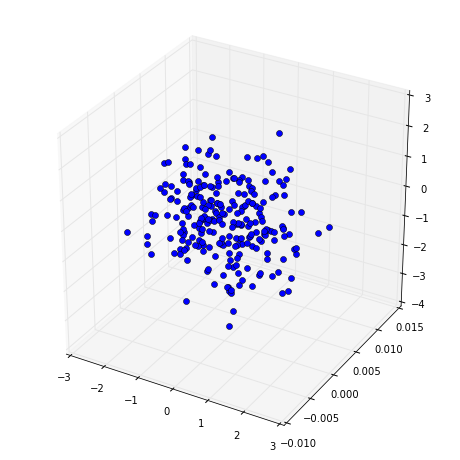

In [19]:
# plot the generated sample
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')  
ax.plot(X[:, 0], X[:, 1], X[:, 2], 'o')

In [20]:
# from http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [21]:
# compute the sample covariance matrix and it's eigenvectors
from numerical.eigen import inverse_iteration
import scipy
sample_cov = np.cov([X[:, 0], X[:, 1], X[:, 2]])

approx_eigvals = [0, 0.9, 1]
eigs = []
for approx_val in approx_eigvals:
    eigs.append(inverse_iteration(sample_cov, approx_val))

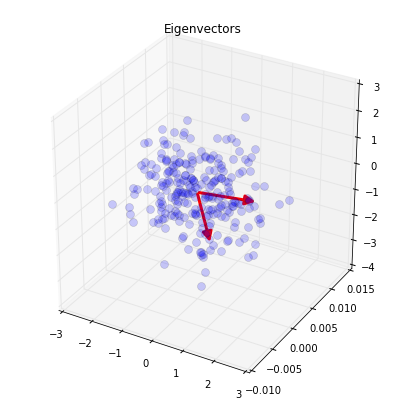

In [22]:
# plot the two eigenvectors corresponding to dominant eigenvalues
# (choose the last two since we know the first principal component
# has almost zero explained variance)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2], 'o', markersize=8, color='blue', alpha=0.2)

for eigvec, eigval in eigs[1:]:
    e = 2 * eigvec
    a = Arrow3D([0, e[0]], [0, e[1]], [0, e[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)

plt.title('Eigenvectors')

In [23]:
# reduce the sample to 2d
W = np.hstack((eigs[1][0].reshape(3,1), eigs[2][0].reshape(3,1)))
X_2d = W.T.dot(X.T).T

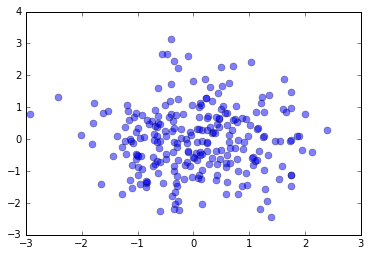

In [24]:
# visualize the transformed sample
plt.plot(X_2d[:, 0], X_2d[:, 1], 'o', markersize=7, color='blue', alpha=0.5)